Reproduce [Chaplin 2010](https://ui.adsabs.harvard.edu/#abs/2010ApJ...713L.169C/abstract) Figure 1

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import kplr
import numpy as np
import sys
sys.path.insert(0, '../')

In [4]:
from astropy.io import fits

# data = fits.getdata('ftp://ftp.pmodwrc.ch/pub/data/irradiance/virgo/'
#                     '1-minute_Data/VIRGO_1min_0083-7404.fits', cache=False)

data = fits.getdata('../data/VIRGO_1min_0083-7404.fits.gz', cache=False)

In [5]:
from interpacf import interpolate_missing_data
import numpy as np
time = np.arange(len(data))
#flux = data[data != 99]

times, fluxes = interpolate_missing_data(time[data != -99], data[data != -99])

fluxes /= np.median(fluxes)

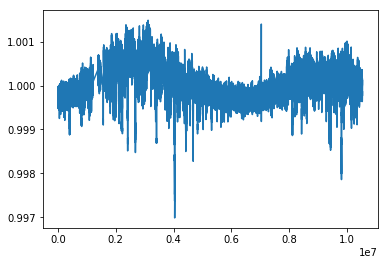

In [6]:
plt.plot(times, fluxes)

In [ ]:
from scipy.signal import periodogram
import os

periodogram_path = 'periodogram.npy'

if os.path.exists(periodogram_path):
    freqs, powers = np.load(periodogram_path)
else: 
    freqs, powers = periodogram(fluxes, fs=1/60)
    freqs *= 1e6
    np.save(periodogram_path, np.vstack([freqs, powers]))

In [ ]:
plt.loglog(freqs, powers, marker=',')

In [8]:
from scipy.stats import binned_statistic

cutoff_freq = 1e5
bs = binned_statistic(np.log(freqs[freqs != 0]), powers[freqs != 0], statistic=np.nanmedian, bins=1000)
bincenters = 0.5 * (bs.bin_edges[:-1] + bs.bin_edges[1:])
binned_power = bs.statistic[np.exp(bincenters) < cutoff_freq]
binned_freq = np.exp(bincenters)[np.exp(bincenters) < cutoff_freq]

/Users/bmmorris/anaconda/lib/python3.5/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


(1e-08, 1e-05)

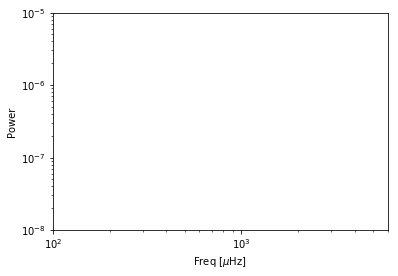

In [12]:
plt.loglog(freqs, powers, ',', alpha=0.5)
plt.loglog(binned_freq, binned_power)
plt.xlabel('Freq [$\mu$Hz]')
plt.ylabel('Power')
plt.xlim([1e2, 6e3])
plt.ylim([1e-8, 1e-5])

(1e-08, 1e-05)

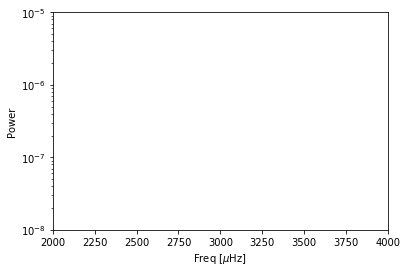

In [13]:
from scipy.ndimage import gaussian_filter1d

plt.semilogy(freqs, powers, ',', alpha=0.5)
# plt.semilogy(freqs[np.argsort(freqs)], gaussian_filter1d(powers[np.argsort(freqs)], 100))
plt.semilogy(binned_freq, binned_power)

plt.xlabel('Freq [$\mu$Hz]')
plt.ylabel('Power')
plt.xlim([2000, 4000])
plt.ylim([1e-8, 1e-5])

In [14]:
from shocksgo import generate_solar_fluxes

In [16]:
from astropy.constants import M_sun, L_sun
import astropy.units as u

times, fluxes, kernel = generate_solar_fluxes(duration=10*u.min)
psd = kernel.get_psd(2*np.pi*freqs*1e-6)

ValueError: negative dimensions are not allowed

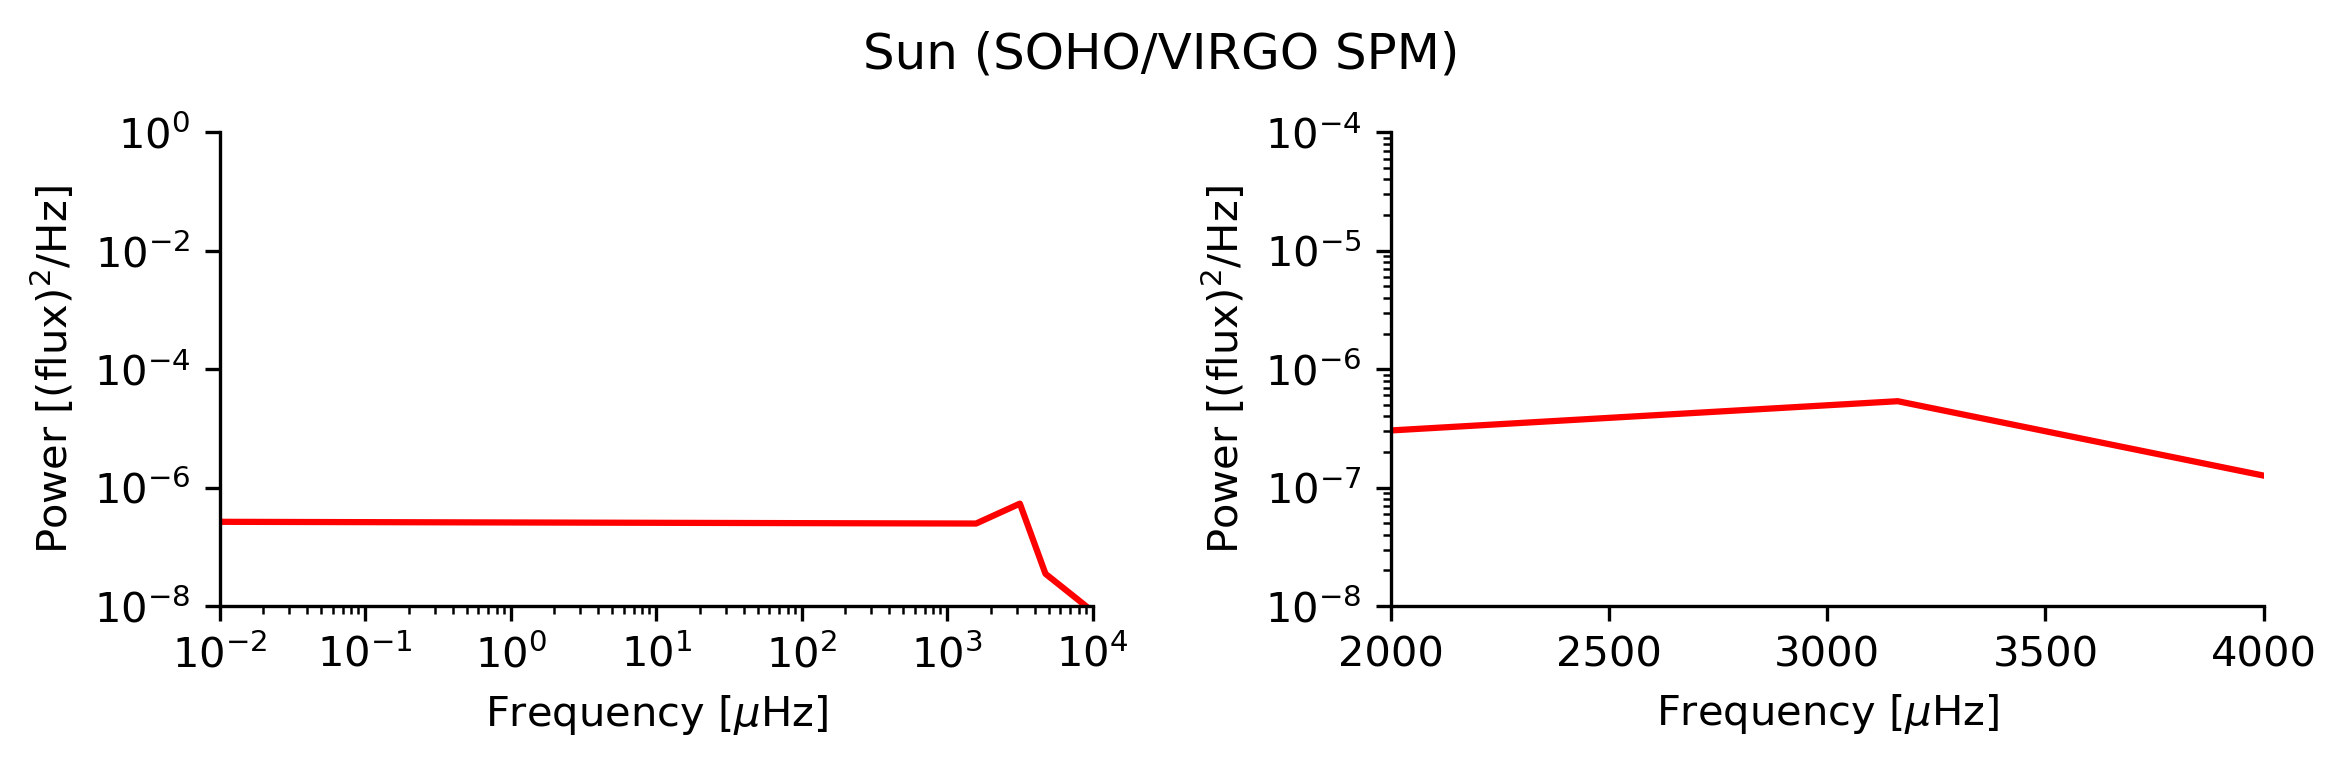

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(8, 2.5))
# ax[0].loglog(binned_freq, binned_power)
ax[0].loglog(freqs, powers, marker=',', lw=0, alpha=0.3, rasterized=True, color='k')

ax[0].loglog(freqs, psd, color='r')
ax[0].set_xlim([1e-2, 1e4])
ax[0].set_ylim([1e-8, 1e0])
ax[0].set_xlabel('Frequency [$\mu$Hz]')
ax[0].set_ylabel('Power [(flux)$^2$/Hz]')

# ax[1].semilogy(binned_freq, binned_power)
ax[1].semilogy(freqs, powers, marker=',', lw=0, alpha=0.3, rasterized=True, color='k')
ax[1].semilogy(freqs, psd, color='r')
ax[1].set_xlim([2000, 4000])
ax[1].set_ylim([1e-8, 1e-4])
ax[1].set_xlabel('Frequency [$\mu$Hz]')
ax[1].set_ylabel('Power [(flux)$^2$/Hz]')

for s in ['right', 'top']:
    for axis in ax: 
        axis.spines[s].set_visible(False)

fig.tight_layout()
fig.suptitle('Sun (SOHO/VIRGO SPM)', va='bottom')
fig.savefig('paper_plots/sun.pdf', bbox_inches='tight', dpi=300)

In [83]:
# durations = []
# for i in np.arange(5, 10):
#     duration = %timeit -o -r 1 generate_solar_fluxes(size=10**i)
#     durations.append(duration)

10 loops, best of 1: 83.7 ms per loop
10 loops, best of 1: 88.3 ms per loop
10 loops, best of 1: 139 ms per loop
1 loop, best of 1: 686 ms per loop
1 loop, best of 1: 6.82 s per loop


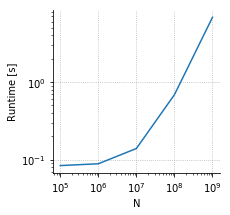

In [84]:
# number_points = 10**np.arange(5, 10)
# duration_best = np.array([duration.best for duration in durations])

# plt.figure(figsize=(3, 3))
# plt.loglog(number_points, duration_best)
# plt.xlabel('N')
# plt.ylabel('Runtime [s]')
# plt.grid(ls=':')
# for s in ['right', 'top']:
#     plt.gca().spines[s].set_visible(False)
# plt.savefig('paper_plots/runtime.pdf', bbox_inches='tight')